# Experimentation

## Dataset profiling

In [1]:
%matplotlib inline
import random
import math
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np

import soli_start
from reviews_soli import ReviewsSolicitation
from data_model import Feature
import uncertainty

file_path = 'datasets/edmunds_reviews.csv'
dataset_profile = soli_start.probe_dataset(file_path)
print(dataset_profile)

Dataset of 5 stars, with 501 products and 53440 reviews
average of feature_rating_count/product = 77.766



Statistics of #reviews/product: min=1, max=1294, average=106.667, std=148.622, median=52.0


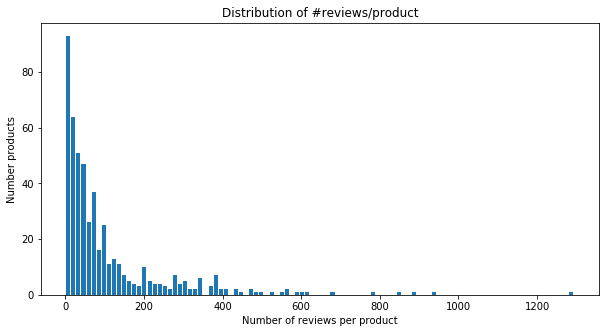

In [2]:
# Distribution of #reviews/product
temp = dataset_profile.per_product_review_counts
print('Statistics of #reviews/product: min={min}, max={max}'
      ', average={average:.3f}, std={std:.3f}, median={median}' \
      .format(min=np.amin(temp), max=np.amax(temp),
              average=np.average(temp), std=np.std(temp), median=np.median(temp)))

fig, ax = plt.subplots(figsize=(10, 5))
_ = ax.hist(dataset_profile.per_product_review_counts, bins=100, rwidth=0.8)
ax.set_xlabel('Number of reviews per product')
ax.set_ylabel('Number products')
ax.set_title('Distribution of #reviews/product')
plt.show()

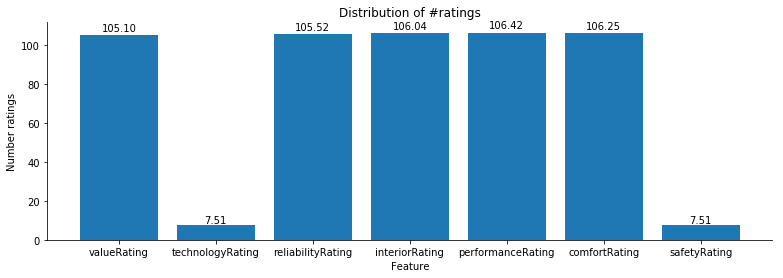

In [3]:
# Distribution of #feature_rating/product
fig, ax = plt.subplots(figsize=(13, 4))
features = list(dataset_profile.feature_to_review_count_average.keys())
num_ratings = list(dataset_profile.feature_to_review_count_average.values())
x_pos = np.arange(len(features))
rects = ax.bar(x_pos, num_ratings)

ax.set_xlabel('Feature')
ax.set_ylabel('Number ratings')
ax.set_title('Distribution of #ratings')
ax.set_xticks(x_pos)
ax.set_xticklabels(features)

for rect, num_rating in zip(rects, num_ratings):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., 1.01*height,
            '{:.2f}'.format(num_rating), ha='center', va='bottom')
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

## Simulation

In [4]:
import pickle

from matplotlib.backends.backend_pdf import PdfPages

from uncertainty import UncertaintyMetric
import soli_start

def partition_goal_by_answer(goal_to_value):
    answer_to_goal_values = OrderedDict()
    for goal, value in goal_to_value.items():
        if goal.answer not in answer_to_goal_values:
            answer_to_goal_values[goal.answer] = OrderedDict()
        answer_to_goal_values[goal.answer][goal] = value

    return answer_to_goal_values


def plot_pick_answer_goals(goal_to_stats_average, dataset="edmunds",
                           poll_max=100, fig_w=20, fig_h=50):
    """
    Args:
        goal_to_stats_average: SoliConfig -> SimulationStats
    """
    stats_sample = list(goal_to_stats_average.values())[0]
    metrics = UncertaintyMetric.metrics()
    answer_to_goal_stats = partition_goal_by_answer(goal_to_stats_average)
    
    subpl_col_count = 2
    subpl_row_count = len(metrics) if dataset == "edmunds" \
                                   else math.ceil(len(metrics) / subpl_col_count)

    X = list(stats_sample.polls)[0:poll_max]
    fig, axarr = plt.subplots(subpl_row_count, subpl_col_count,
                              figsize=(fig_w, fig_h),
                              subplot_kw=dict(xlabel='Number of polls'))  
    subpl_idx = 0
    for metric_idx, metric in enumerate(metrics):        
        for answer, goal_to_stats_average in answer_to_goal_stats.items():
            # each goal is plotted by a curve
            for goal, stats in goal_to_stats_average.items():
                ax = axarr[subpl_idx // subpl_col_count, subpl_idx % subpl_col_count]
                if goal.optm_goal \
                        and goal.optm_goal not in UncertaintyMetric.optm_goals()[:-1]:
                    continue
                Y = [report.get_uncertainty_total(metric)
                     for report in stats.uncertainty_reports[0:poll_max]]
                ax.plot(X, Y, label=goal.pick_goal_str())
                
                ax.set_title('Cost change over polls ({})'.format(answer))
                ax.set_ylabel(str(metric))
                ax.legend(loc='upper right')
            subpl_idx += 1

    plt.show()
    return fig

def plot_ratings(goal_to_stats_average, dataset="edmunds",
                 polls=[50, 100], fig_w=20, fig_h=20):

    answer_count = 2 if dataset == "edmunds" else 1
    subpl_col_count = 2    
    # When there's only 1 answer mth, still stack 2 subplot on a row
    subpl_row_count = math.ceil(len(polls) / (subpl_col_count / answer_count))
   
    fig, axarr = plt.subplots(subpl_row_count, subpl_col_count,
                              figsize=(fig_w, fig_h), sharey=True,
                              subplot_kw=dict(xlabel='Number of ratings'))
    features = list(goal_to_stats_average.values())[0].features
    
    Y = np.arange(len(goal_to_stats_average) / answer_count, 0, -1)
    width = 1 / (1 + len(features))

    answer_to_goal_stats = partition_goal_by_answer(goal_to_stats_average)
    subpl_idx = 0
    for poll in polls:
        for answer, goal_to_stats in answer_to_goal_stats.items():
            if subpl_row_count == 1:
                ax = axarr[subpl_idx]
            else:
                ax = axarr[subpl_idx // subpl_col_count, subpl_idx % subpl_col_count]
            # plot each goal's stats by a set of horizontal bars
            for feature in features:
                X = [np.sum(stats_average.poll_to_report[poll - 1].ratings[feature.idx, :])
                     for stats_average in goal_to_stats.values()]                                
                Y_pos = Y - feature.idx * width
                ax.barh(Y_pos, X, width, label=feature.name)

            Y_pos_mid = Y - len(features) / 2 * width
            ax.set_yticks(Y_pos_mid)
            ax.set_yticklabels([goal.pick_goal_str()
                                         for goal in goal_to_stats.keys()])
            ax.set_title("Rating distribution after {} polls ({})".format(
                poll, answer))
            ax.legend(loc='upper right')
            
            if answer_count == 2:
                subpl_idx += 1
        
        if answer_count != 2:
            subpl_idx += 1

    plt.show()
    return fig

def plot_aspect_rating_dist(product, aspect_to_sentiment_count,
                            fig_w=20, fig_h=5,
                            star_rank=6):
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    
    aspects = list(aspect_to_sentiment_count.keys())
    X = np.arange(len(aspects))
    width = 1 / (star_rank + 1)
    for star in range(1, star_rank + 1):
        X_left = X + (star - 1) * width
        Y = [sentiment_count[star]
             for sentiment_count in aspect_to_sentiment_count.values()]        
        ax.bar(X_left, Y, width, label="{} stars".format(star))

    X_mid = X + (star_rank - 1) / 2 * width
    ax.set_xticks(X_mid)
    ax.set_xticklabels(aspects)
    
    ax.set_title("Rating distribution of {}".format(product))
    ax.legend(loc='upper right')
    ax.set_xlabel('Aspects')
    ax.set_ylabel('Rating Count')
    plt.show()
    return fig

------------------------output/edmunds_l950_p300_q2.pickle------------------------



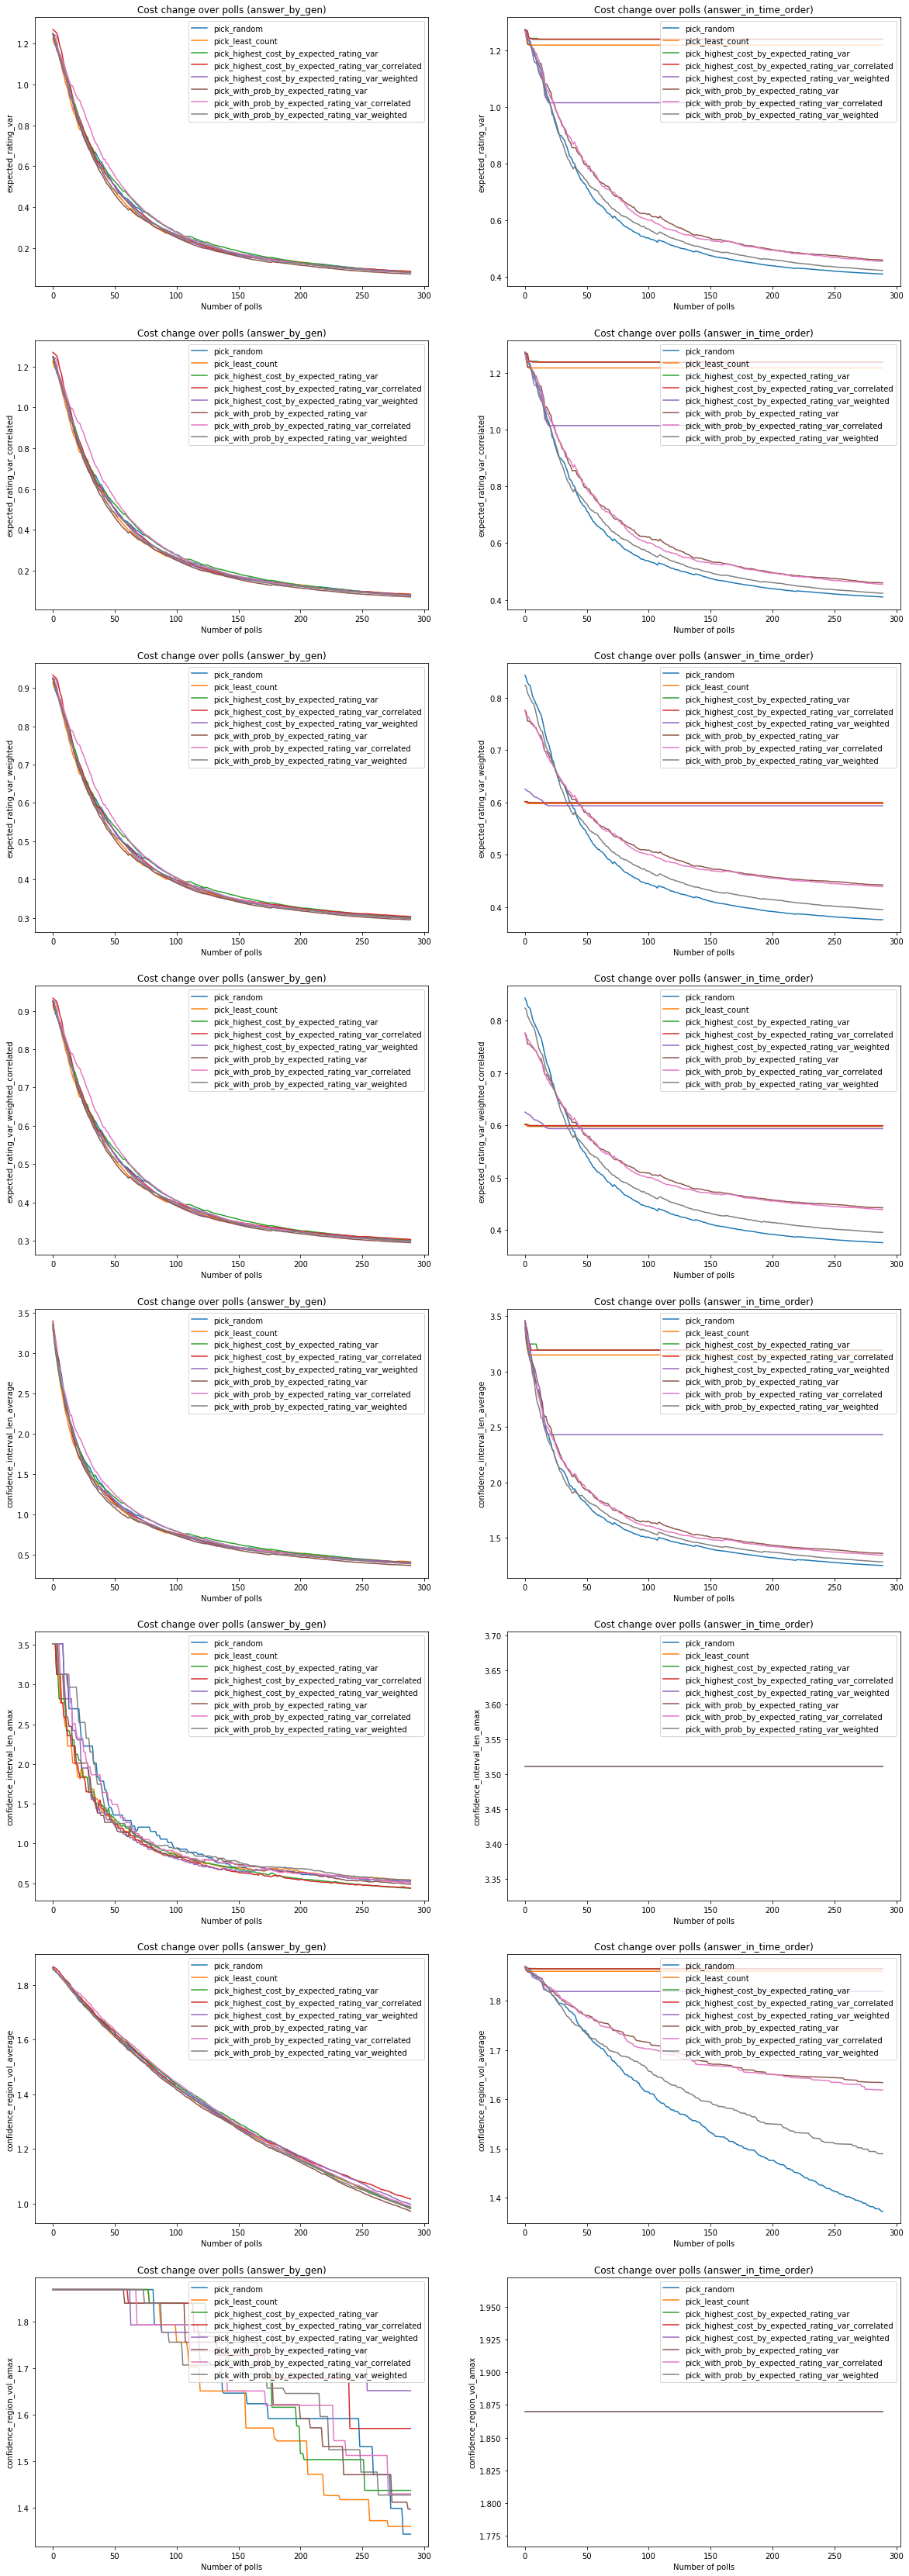

------------------------Rating distribution------------------------



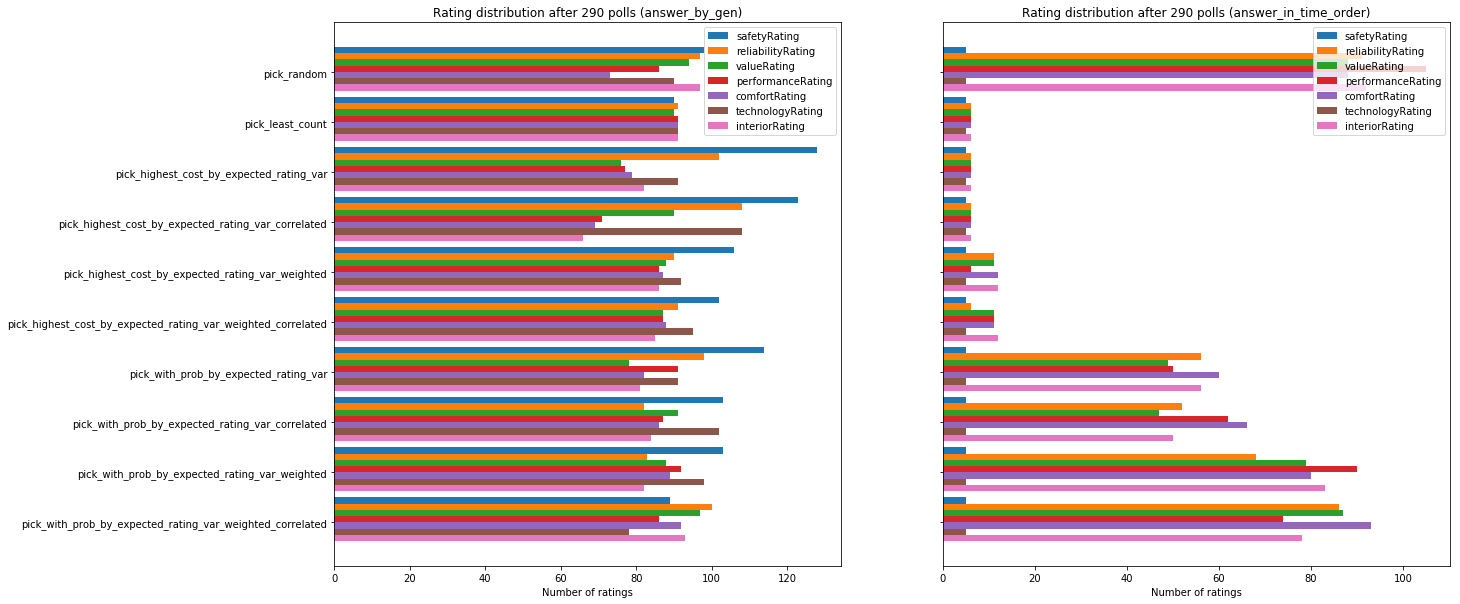

In [5]:
edmunds_pdf = PdfPages('plots/edmunds_l950_p300.pdf')
#sim_result_paths = ['output/edmunds_l300_p300_q2.pickle', 'output/edmunds_l300_p300_q2_dup.pickle']
sim_result_paths = ['output/edmunds_l950_p300_q2.pickle']
path_to_goal_stats = OrderedDict()
plotted_poll_end=290
#from IPython.core.debugger import Tracer; Tracer()()
for sim_result_path in sim_result_paths:
    with open(sim_result_path, 'rb') as f:
        product_to_config_stats = pickle.load(f)
   
    goal_to_stats_average = soli_start.summary_product_to_config_stats(
        product_to_config_stats, plotted_poll_end=plotted_poll_end)
    path_to_goal_stats[sim_result_path] = goal_to_stats_average

for path, goal_to_stats_average in path_to_goal_stats.items():
    print('------------------------{}------------------------\n'.format(path))
    fig = plot_pick_answer_goals(goal_to_stats_average,
                                 poll_max=plotted_poll_end, fig_h=60)
    edmunds_pdf.savefig(fig)
    
    print('------------------------Rating distribution------------------------\n')
    fig = plot_ratings(goal_to_stats_average,
                       polls=[plotted_poll_end], fig_h=10)
    edmunds_pdf.savefig(fig)
edmunds_pdf.close()

2017-05-31 21:04:02,734-DEBUG - Creative Labs Nomad Jukebox Zen Xtra 40GB
2017-05-31 21:04:02,738-DEBUG - Canon G3
2017-05-31 21:04:02,741-DEBUG - Nikon coolpix 4300
2017-05-31 21:04:02,745-DEBUG - Apex AD2600 Progressive-scan DVD player
2017-05-31 21:04:02,747-DEBUG - Nokia 6610
2017-05-31 21:04:02,750-DEBUG - norton
2017-05-31 21:04:02,752-DEBUG - Hitachi router
2017-05-31 21:04:02,754-DEBUG - Product with less than 3 aspects: Canon PowerShot SD500
2017-05-31 21:04:02,756-DEBUG - Product with less than 3 aspects: ipod
2017-05-31 21:04:02,758-DEBUG - Canon S100
2017-05-31 21:04:02,761-DEBUG - Product with less than 3 aspects: Linksys Router
2017-05-31 21:04:02,765-DEBUG - MicroMP3
2017-05-31 21:04:02,768-DEBUG - Nokia 6600
2017-05-31 21:04:02,771-DEBUG - Diaper Champ
2017-05-31 21:04:02,771-DEBUG - 11 products with aspects of at least 10 ratings


------------------------output/bliu_l100_p200_q2.pickle------------------------



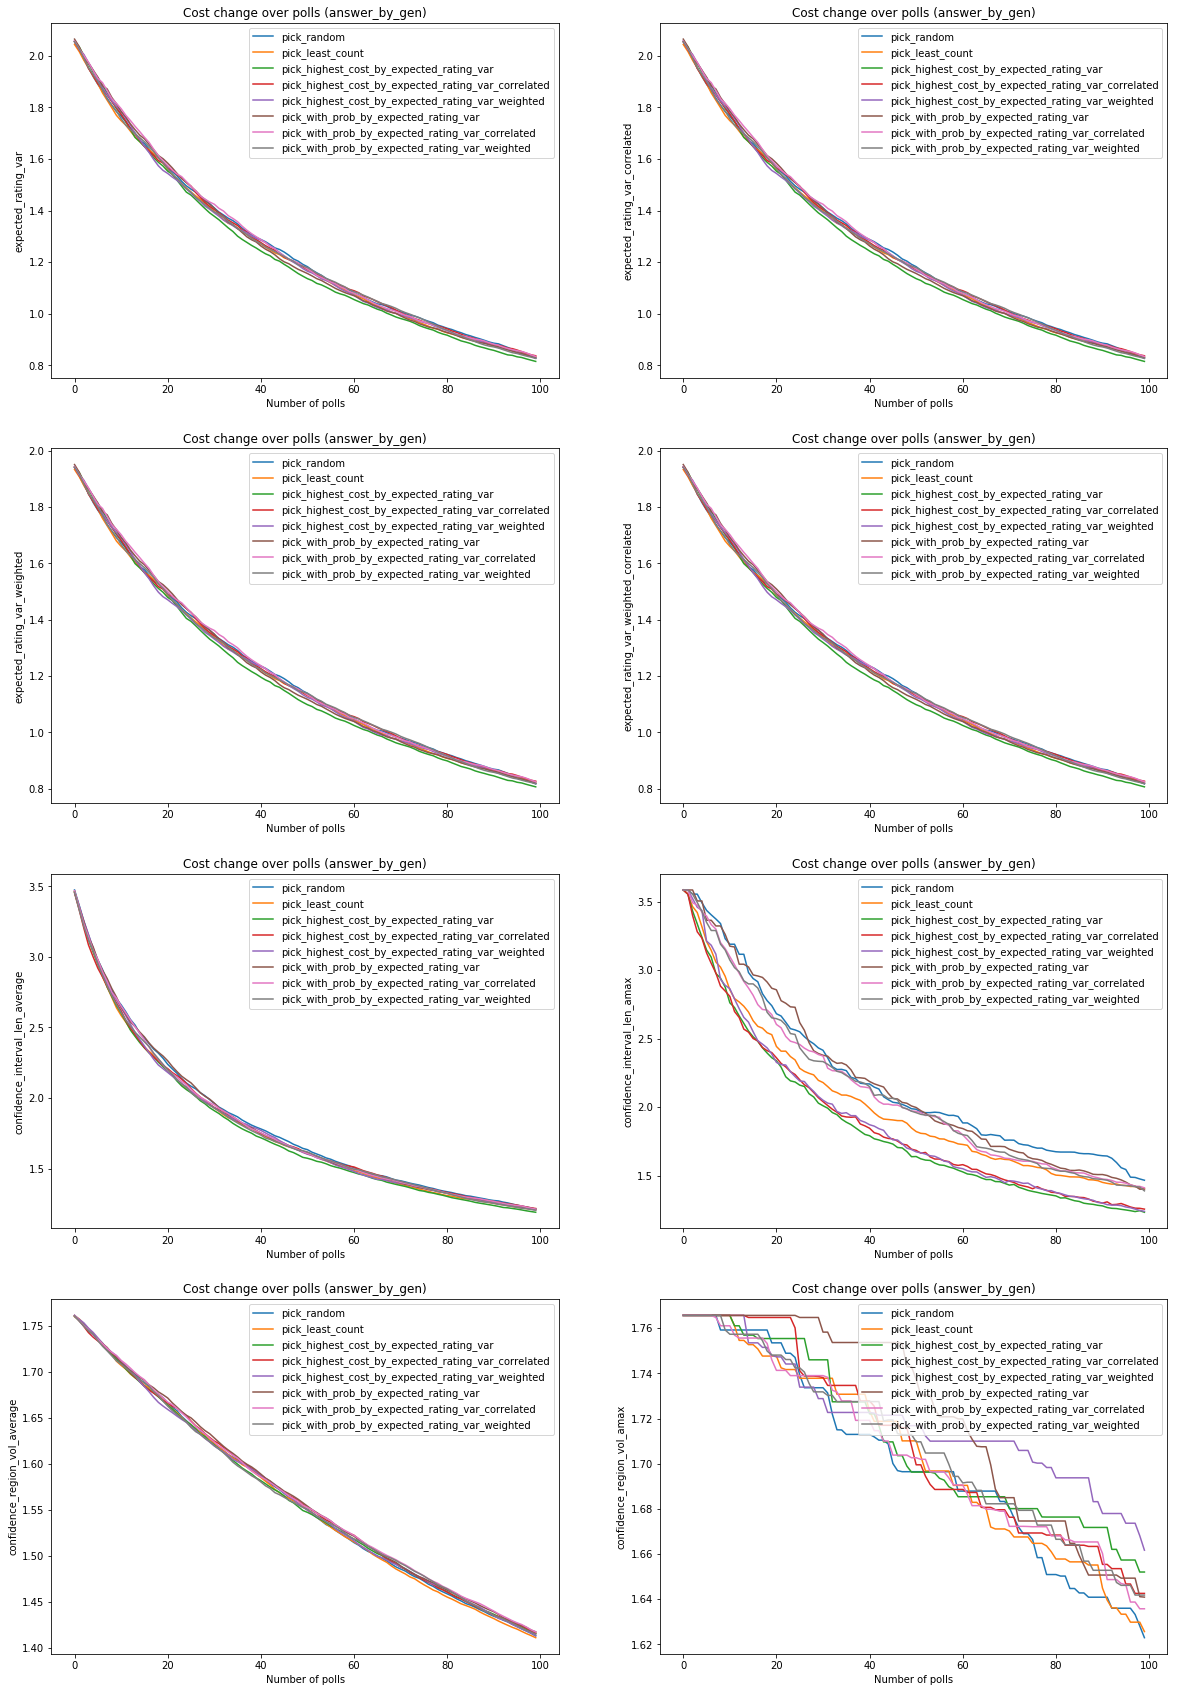

------------------------output/bliu_l100_p200_q2.pickle------------------------



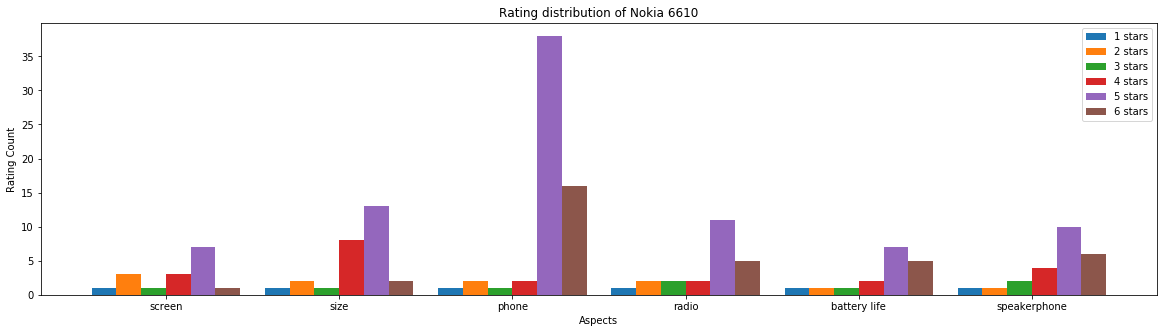

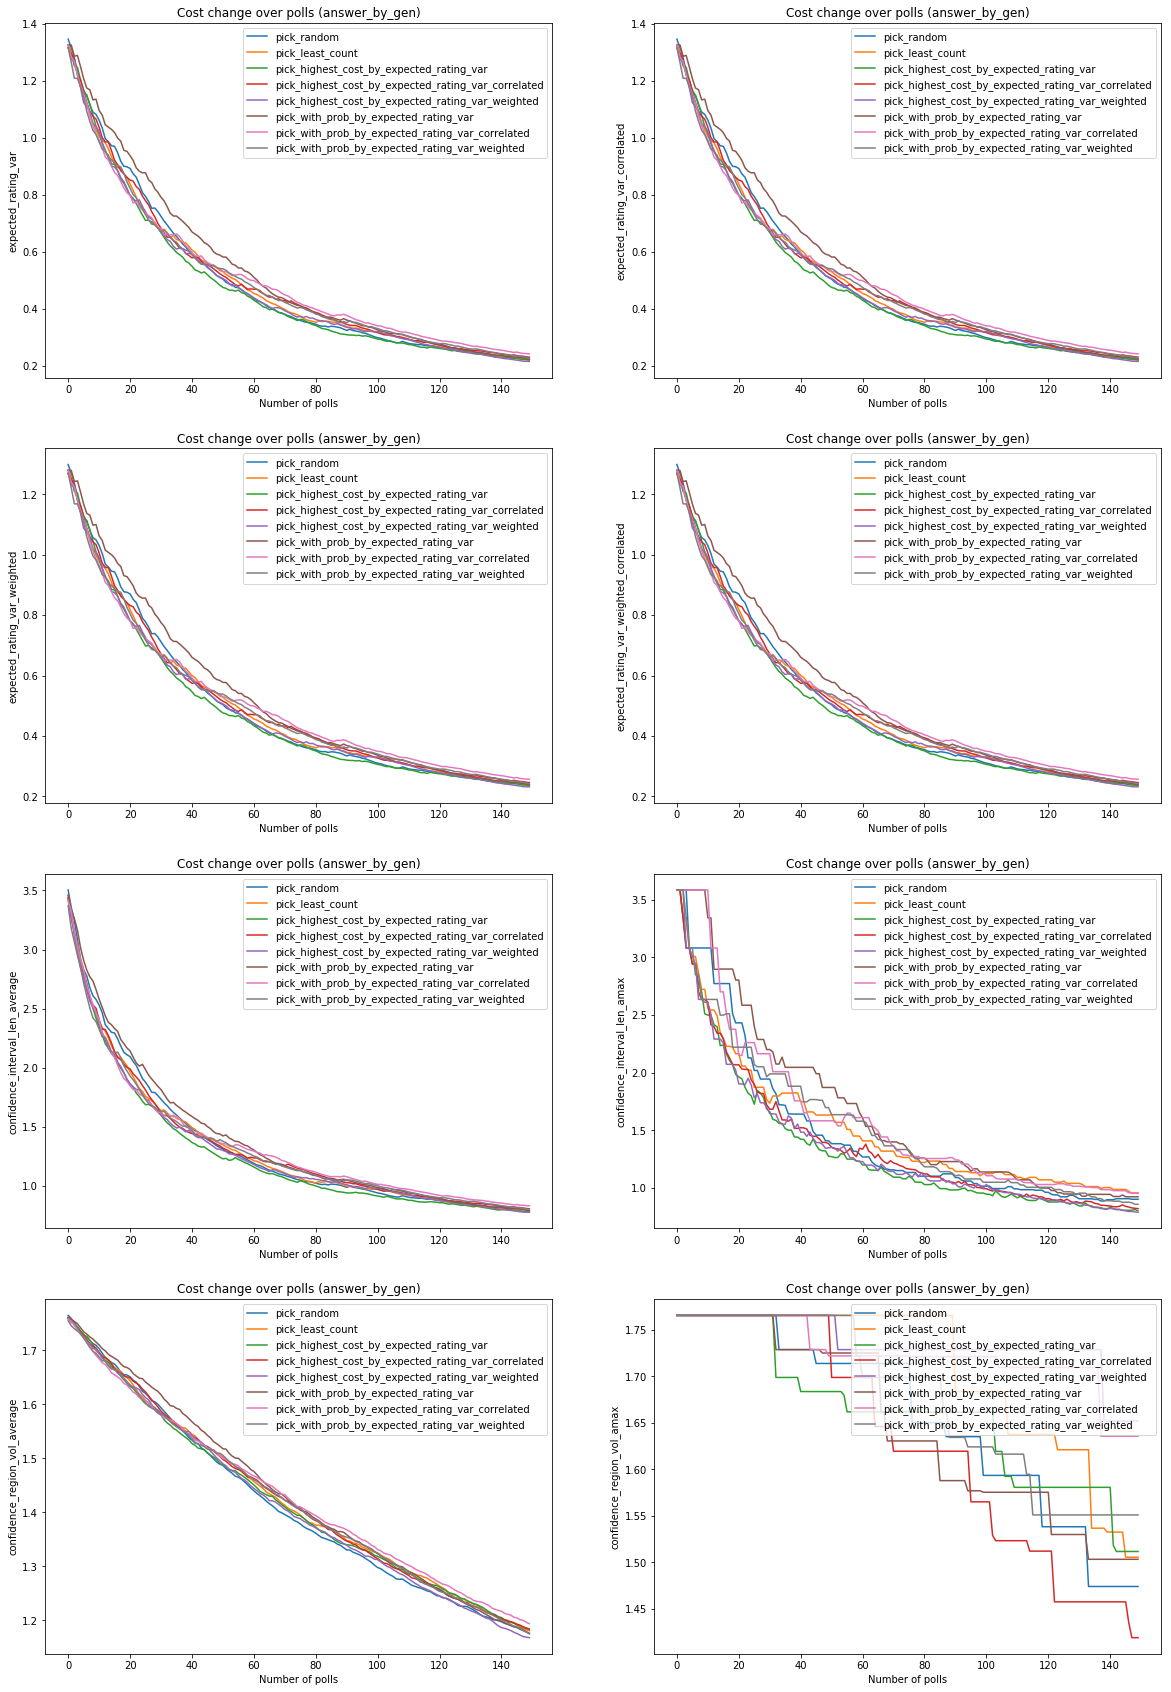

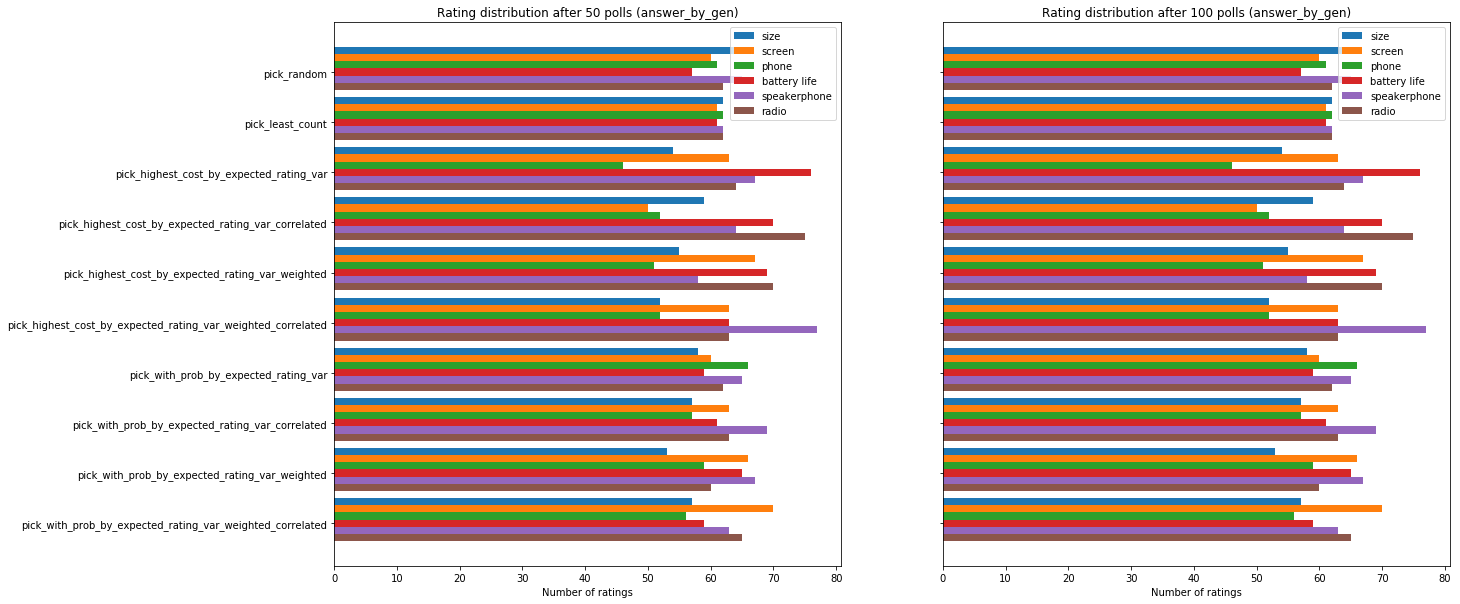

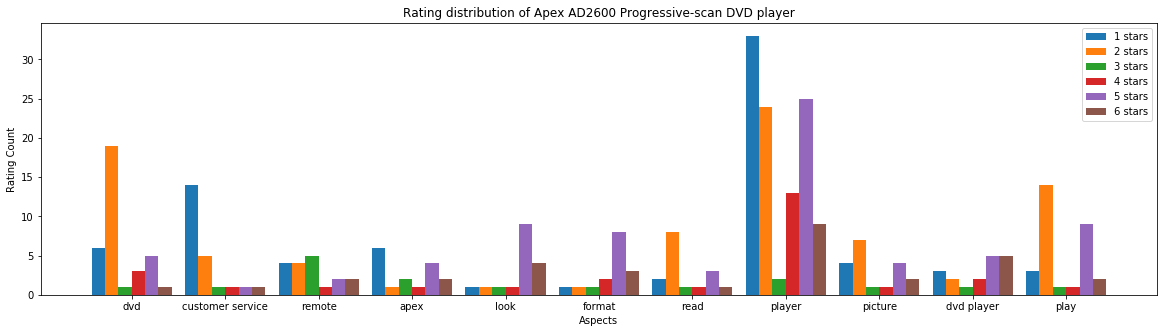

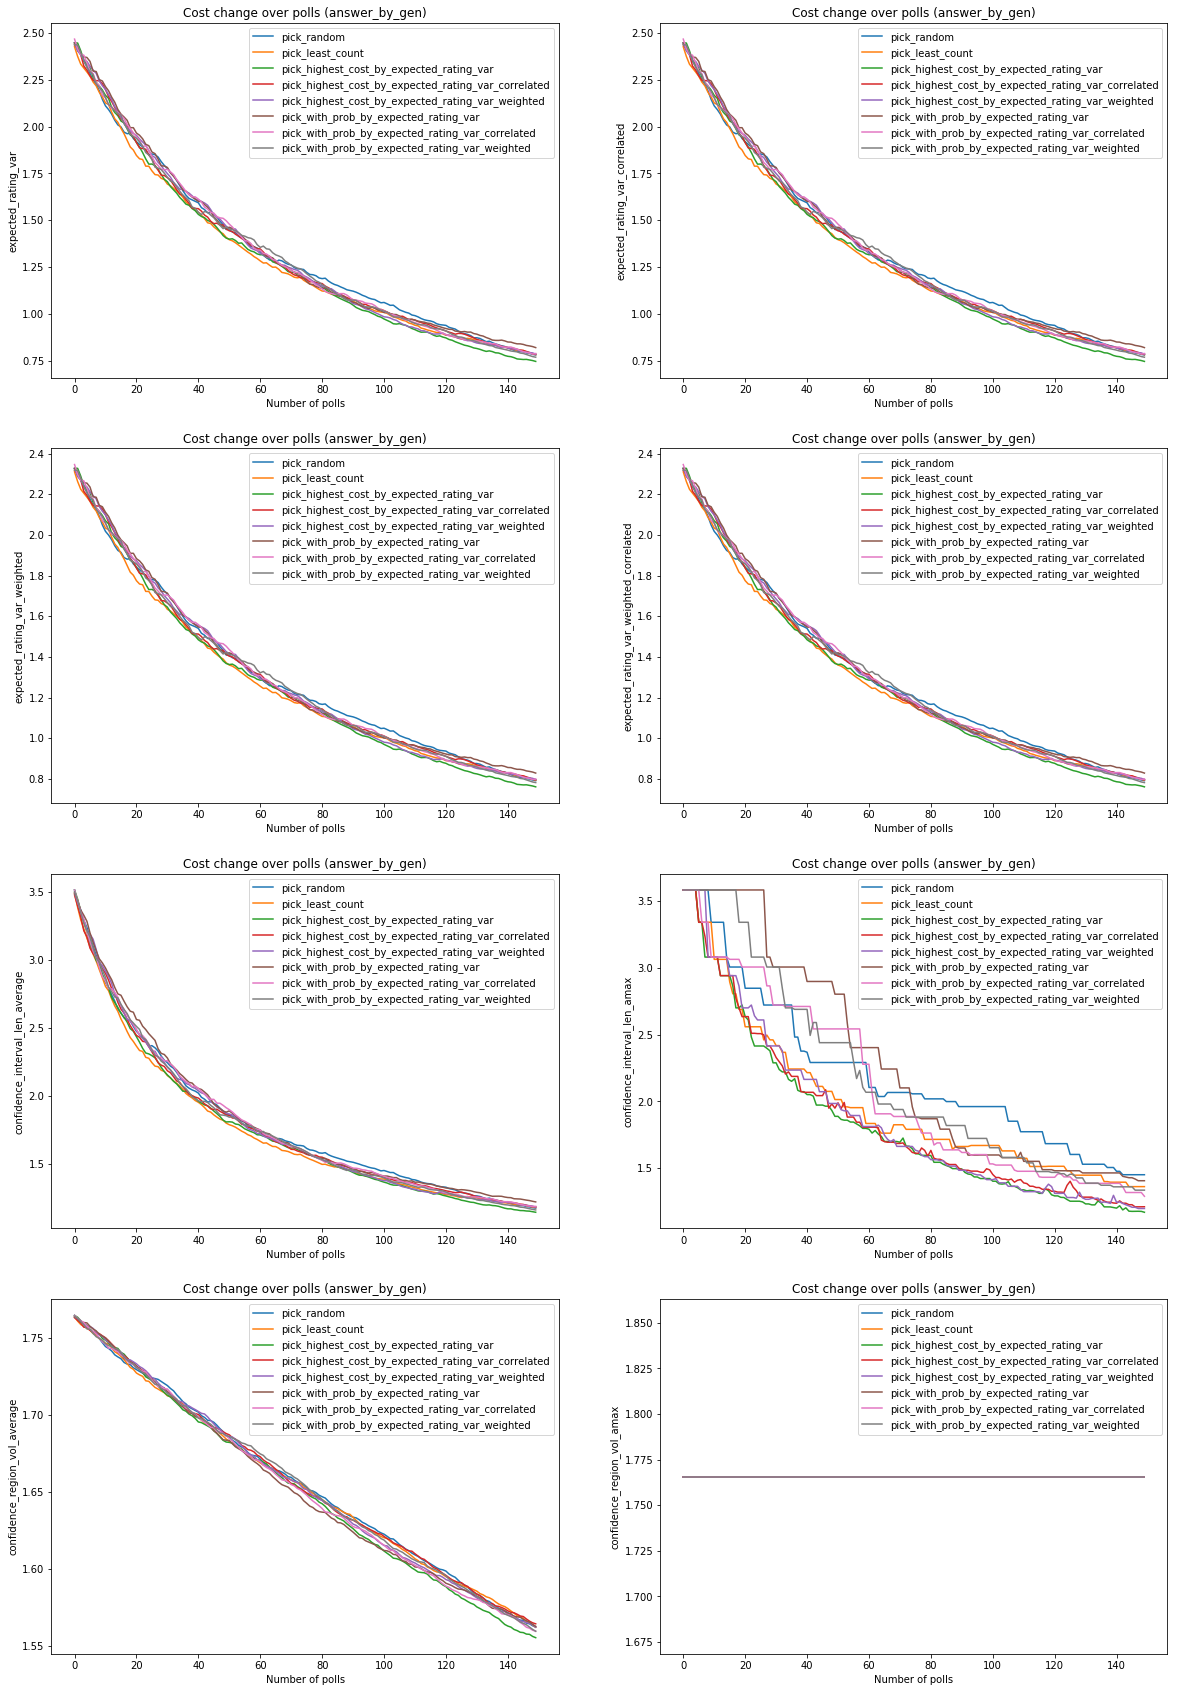

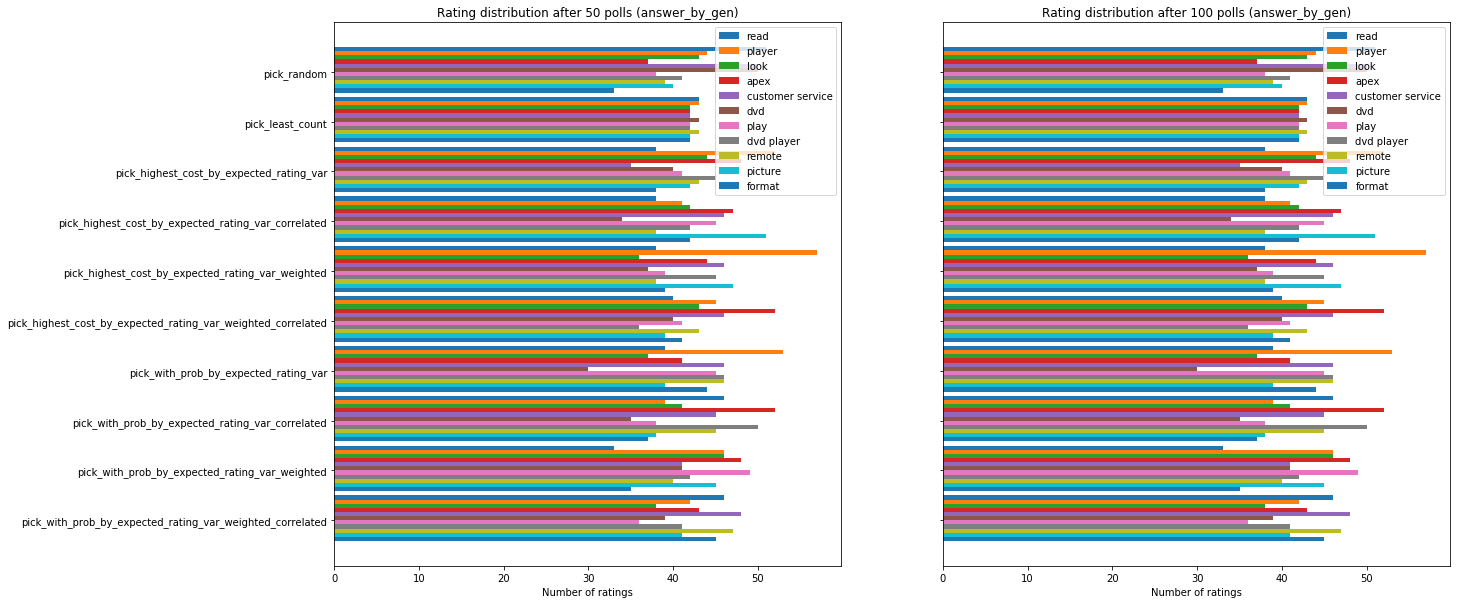

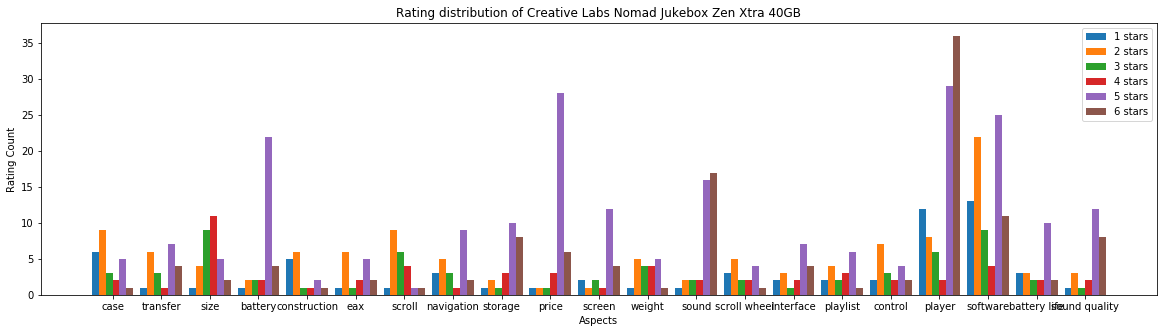

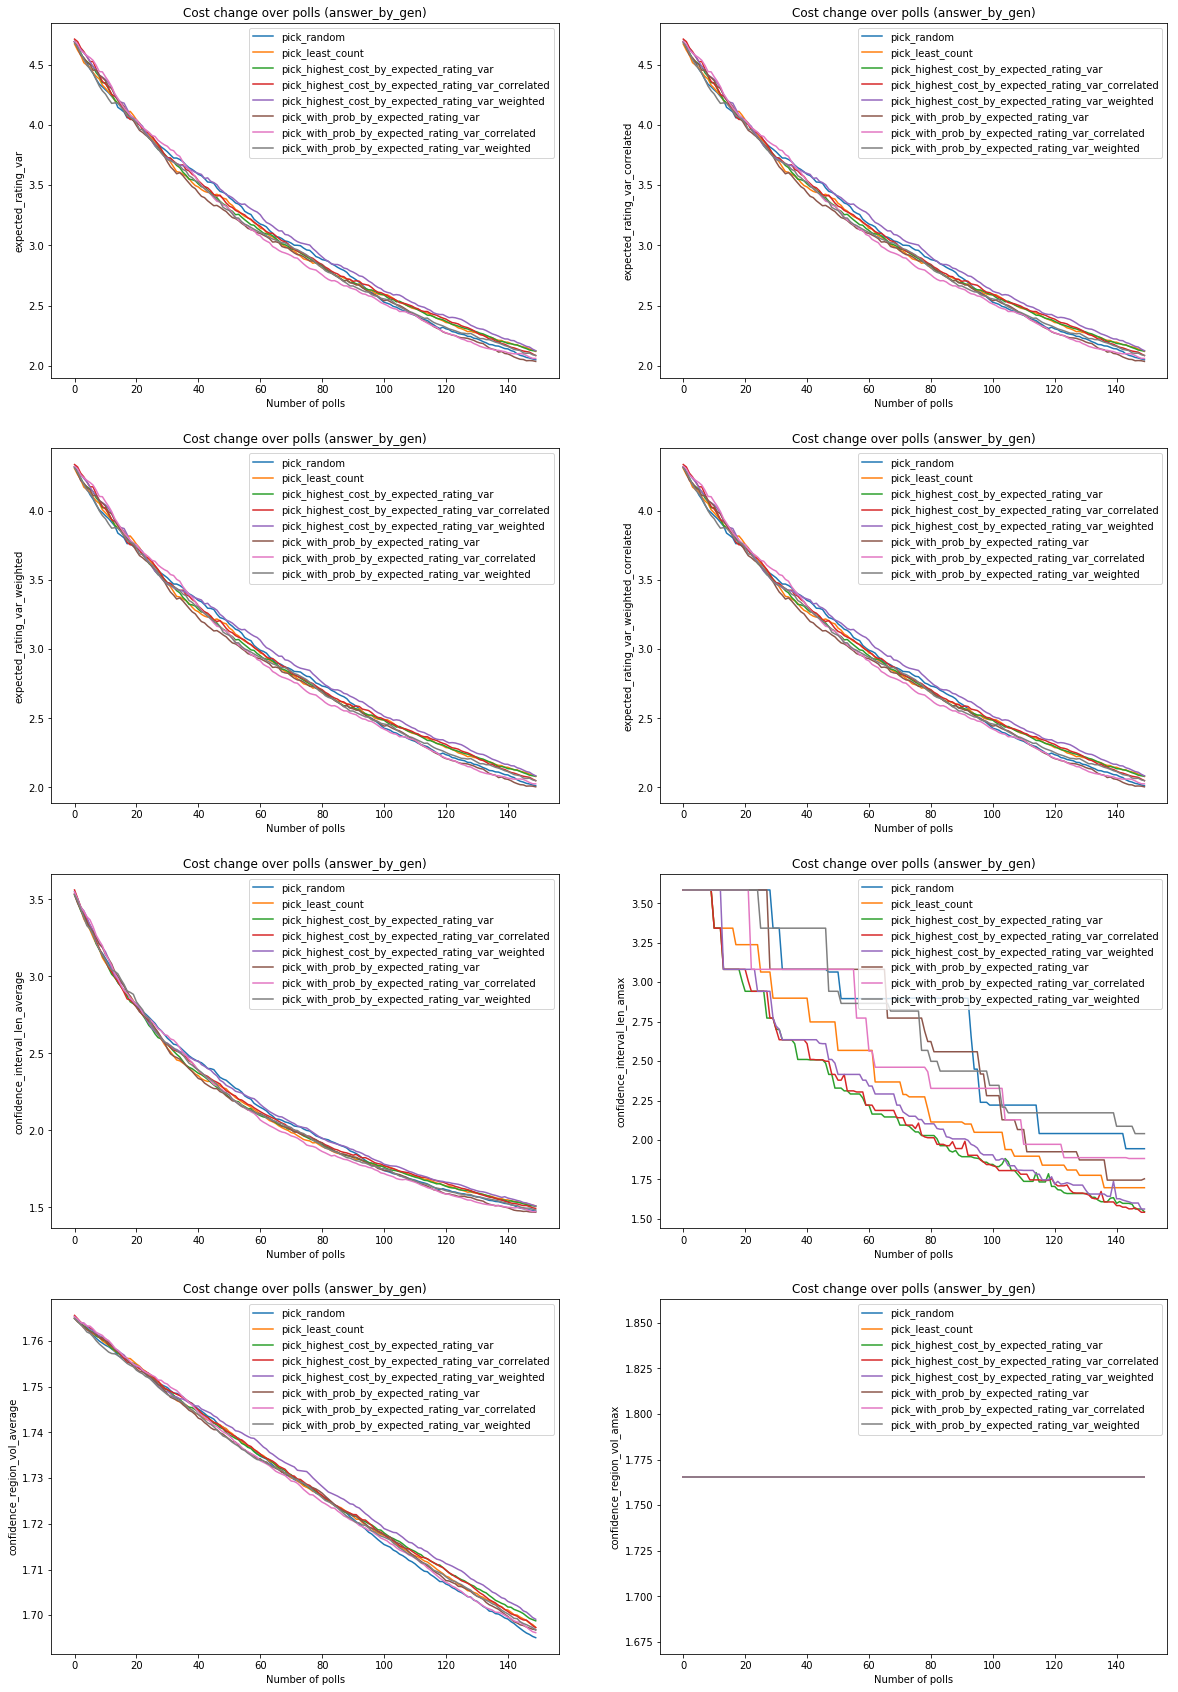

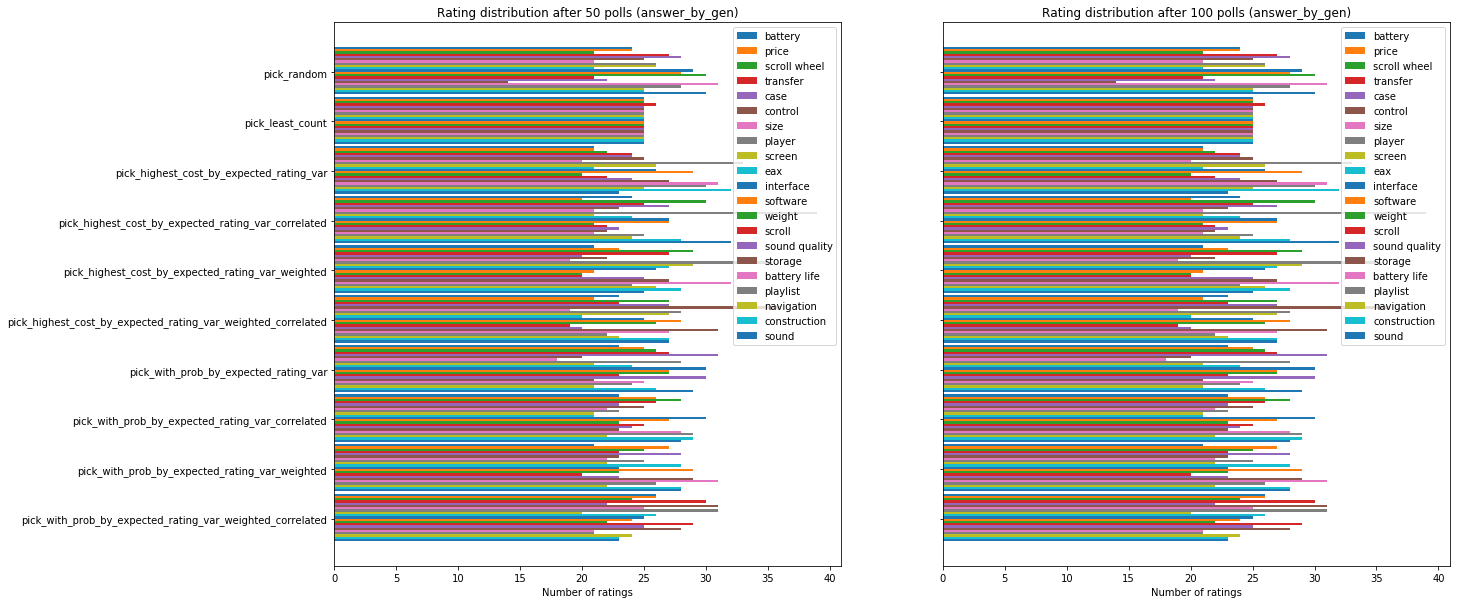

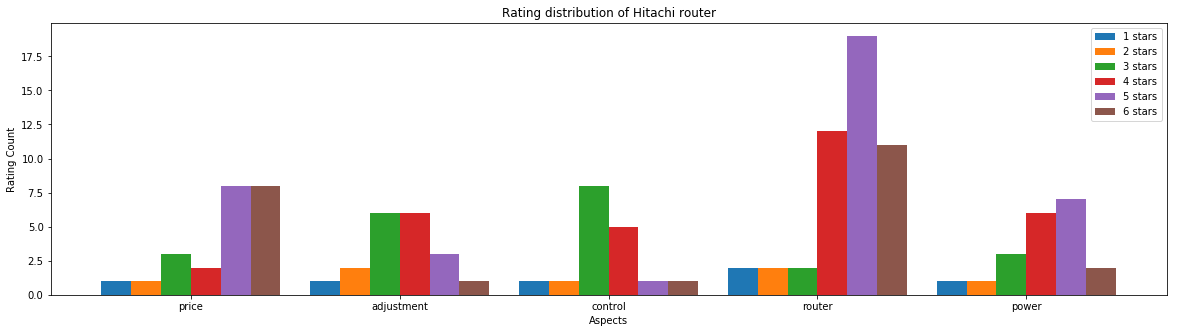

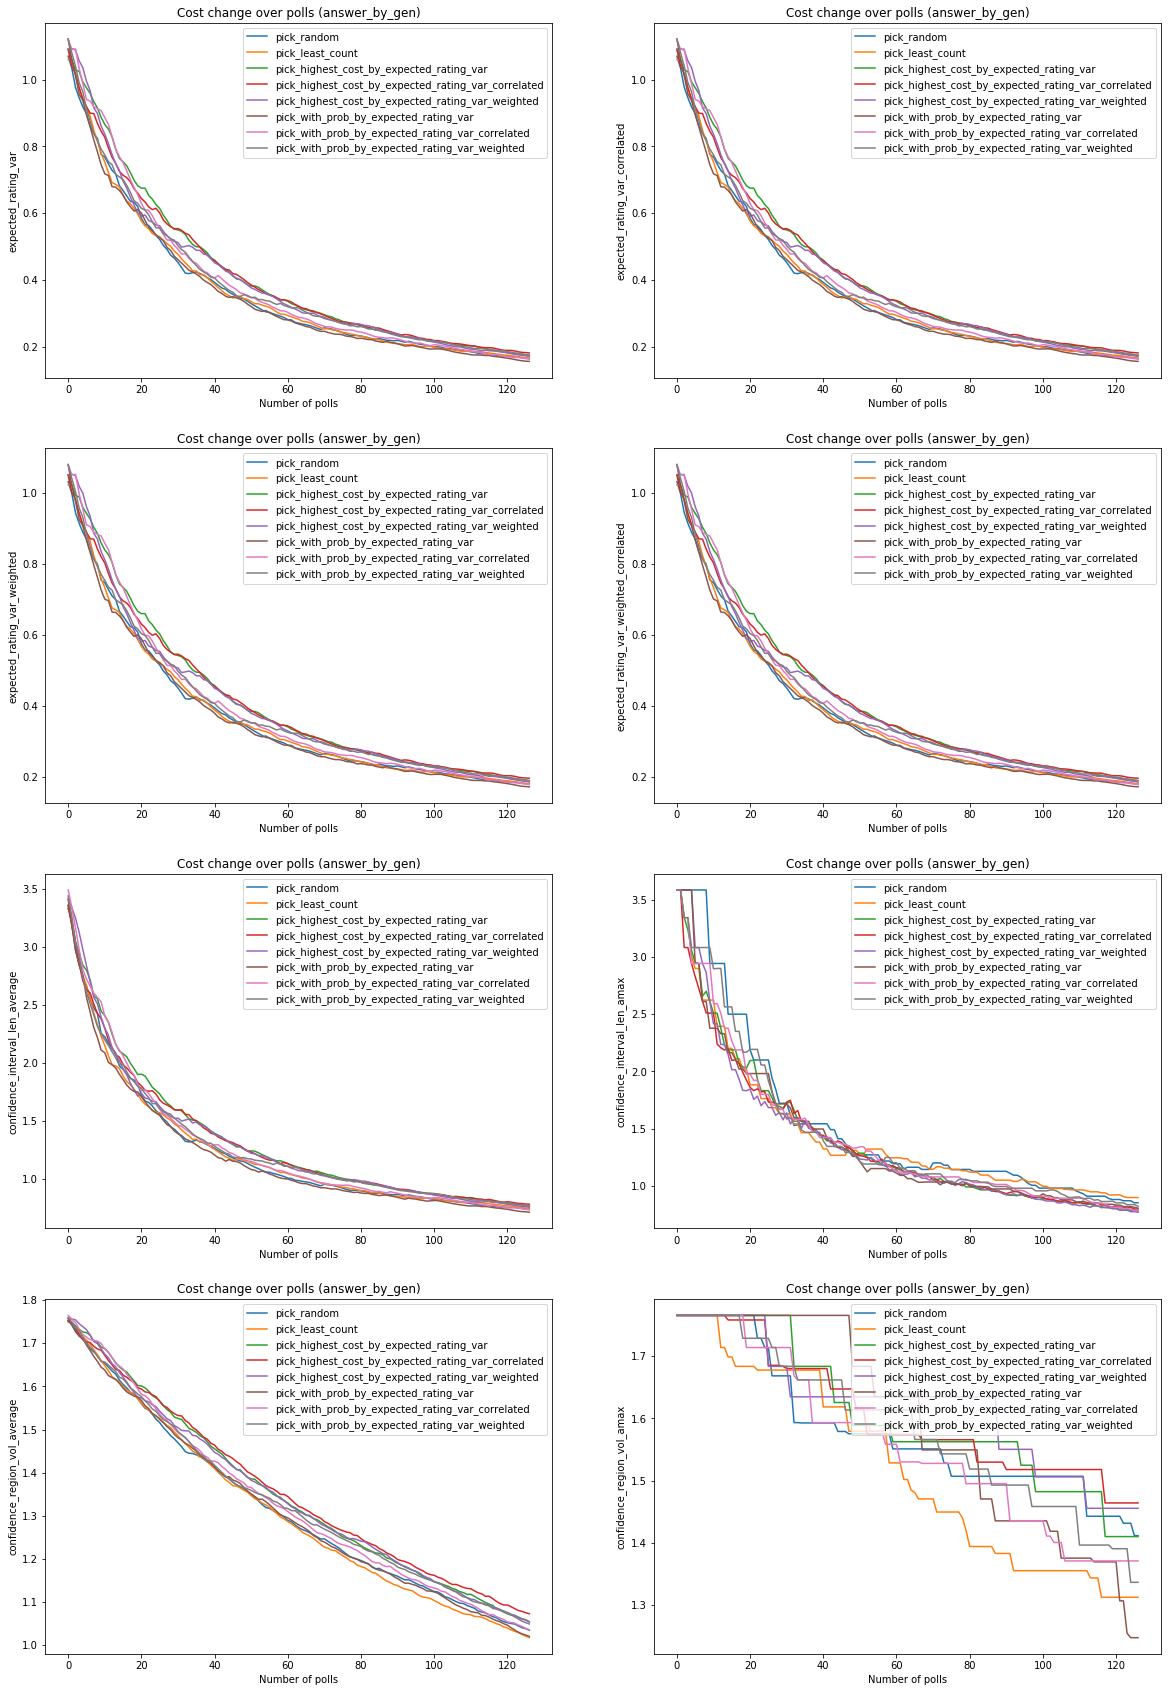

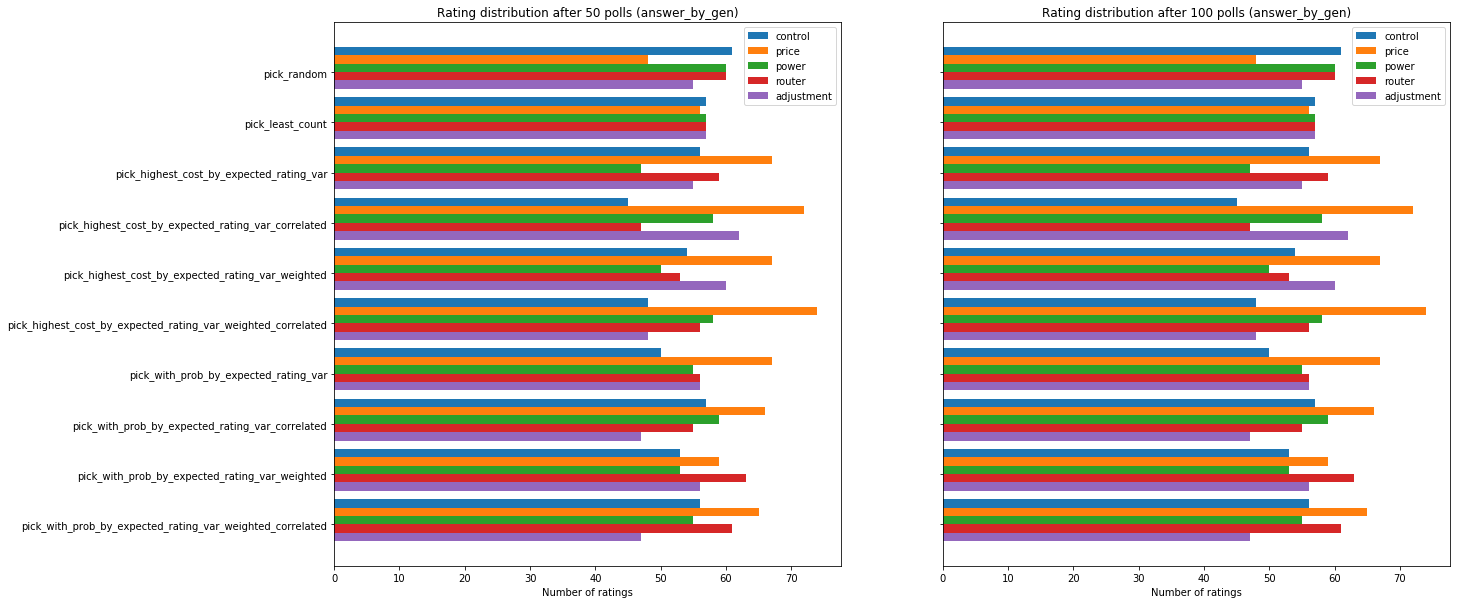

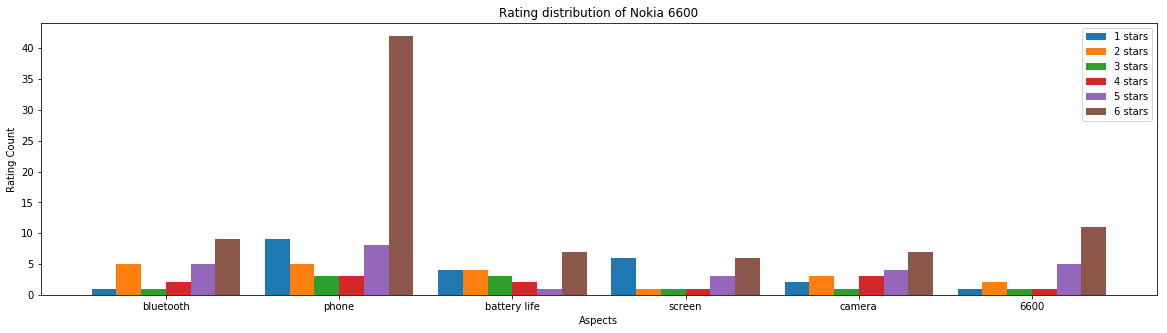

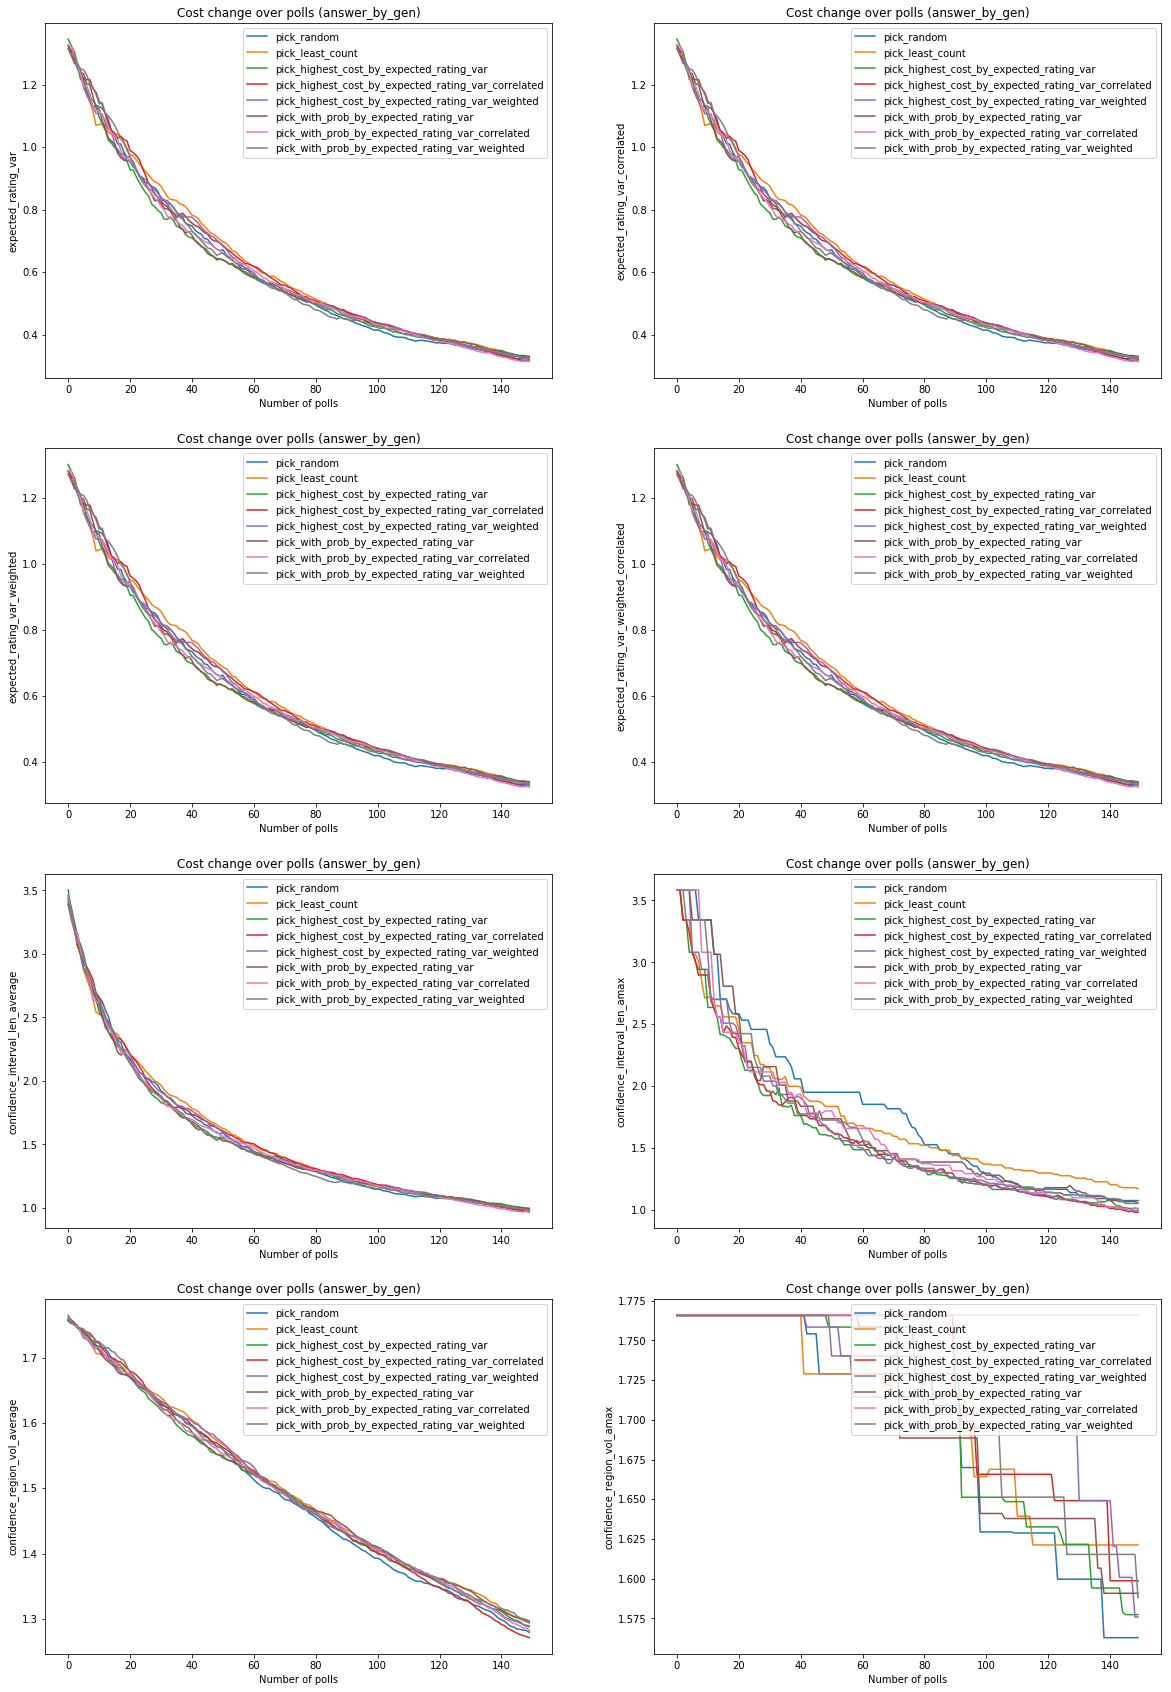

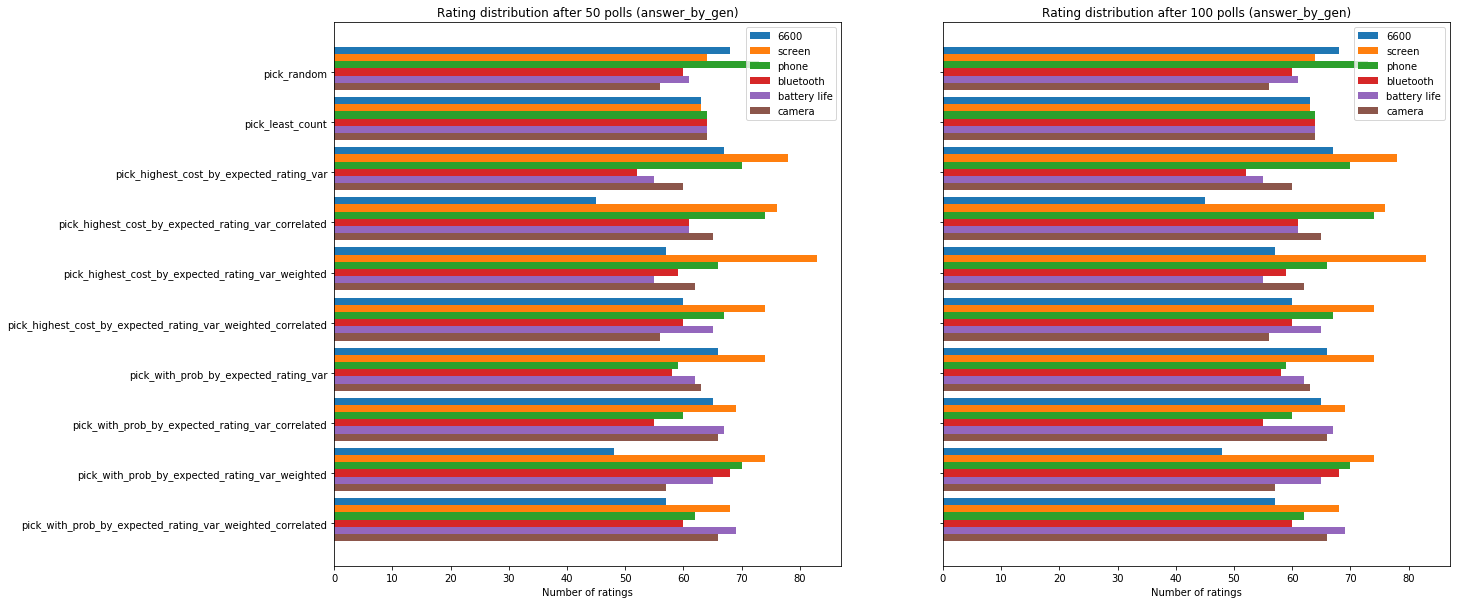

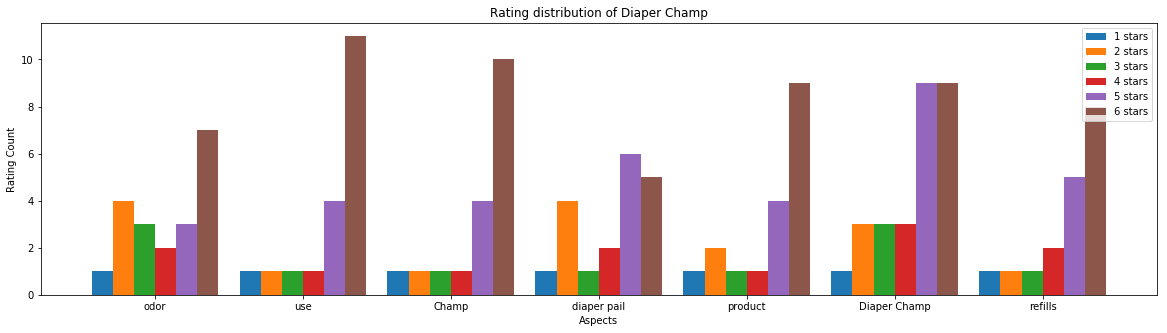

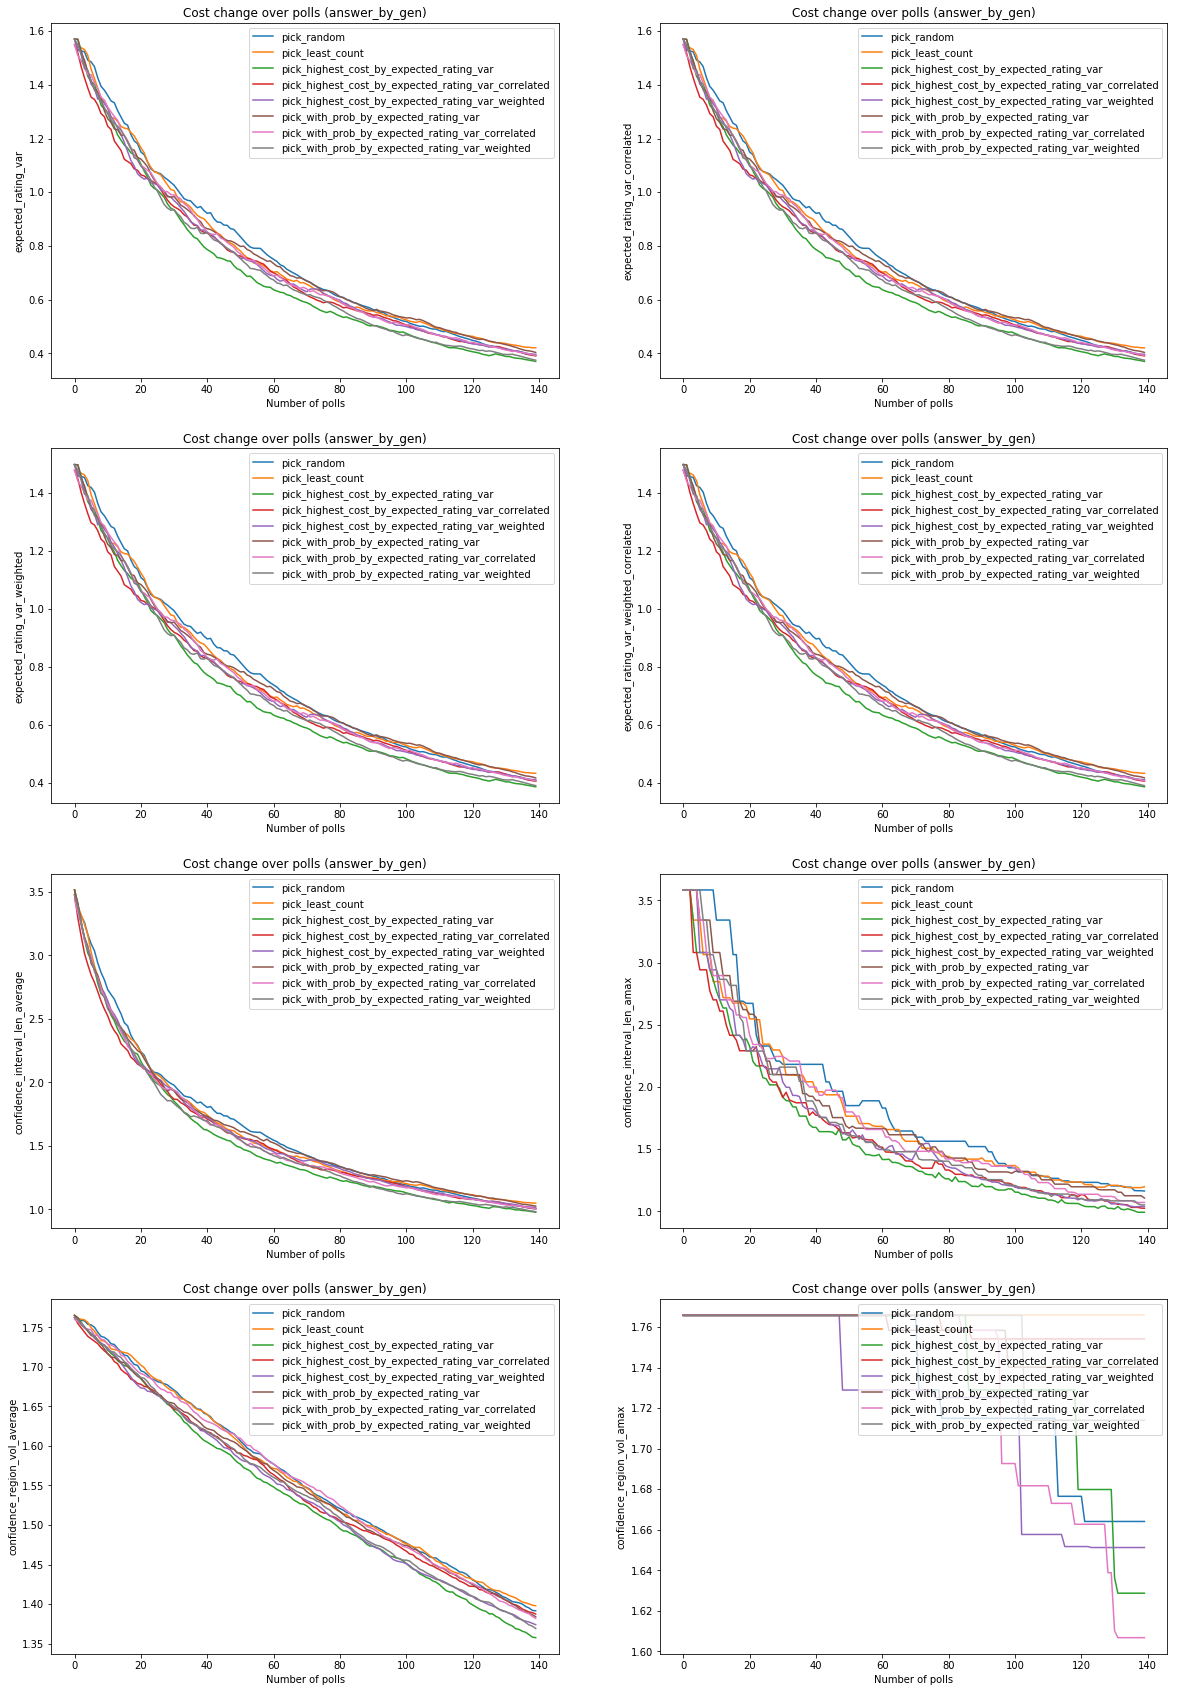

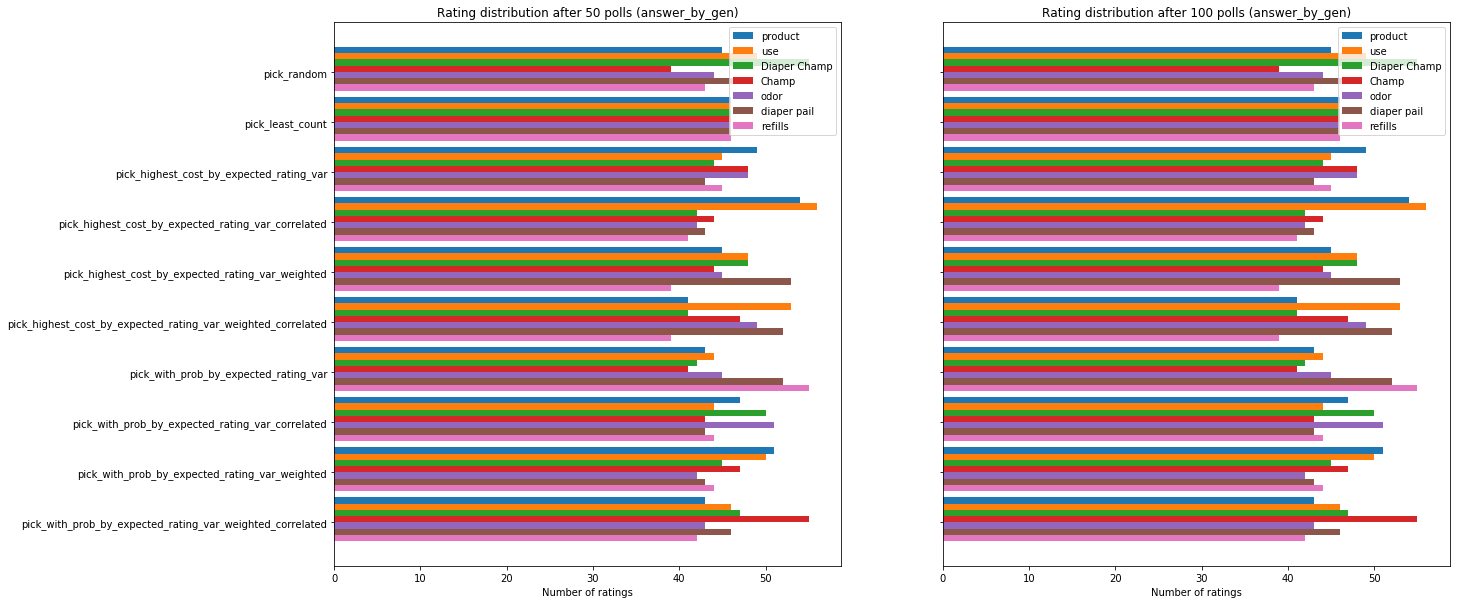

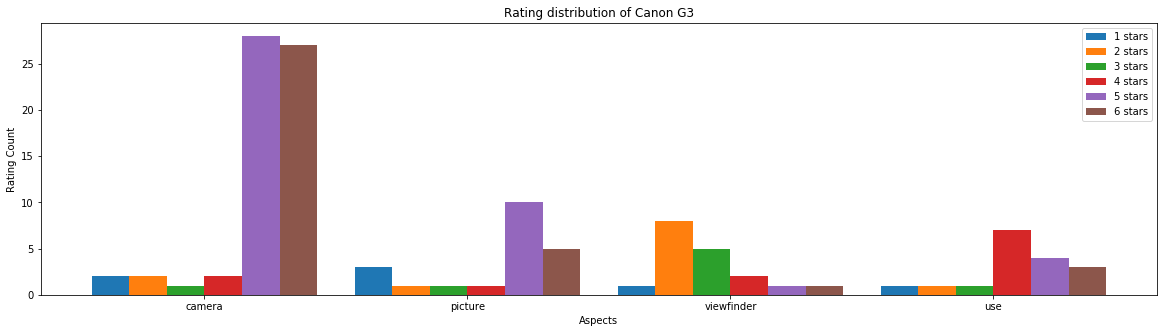

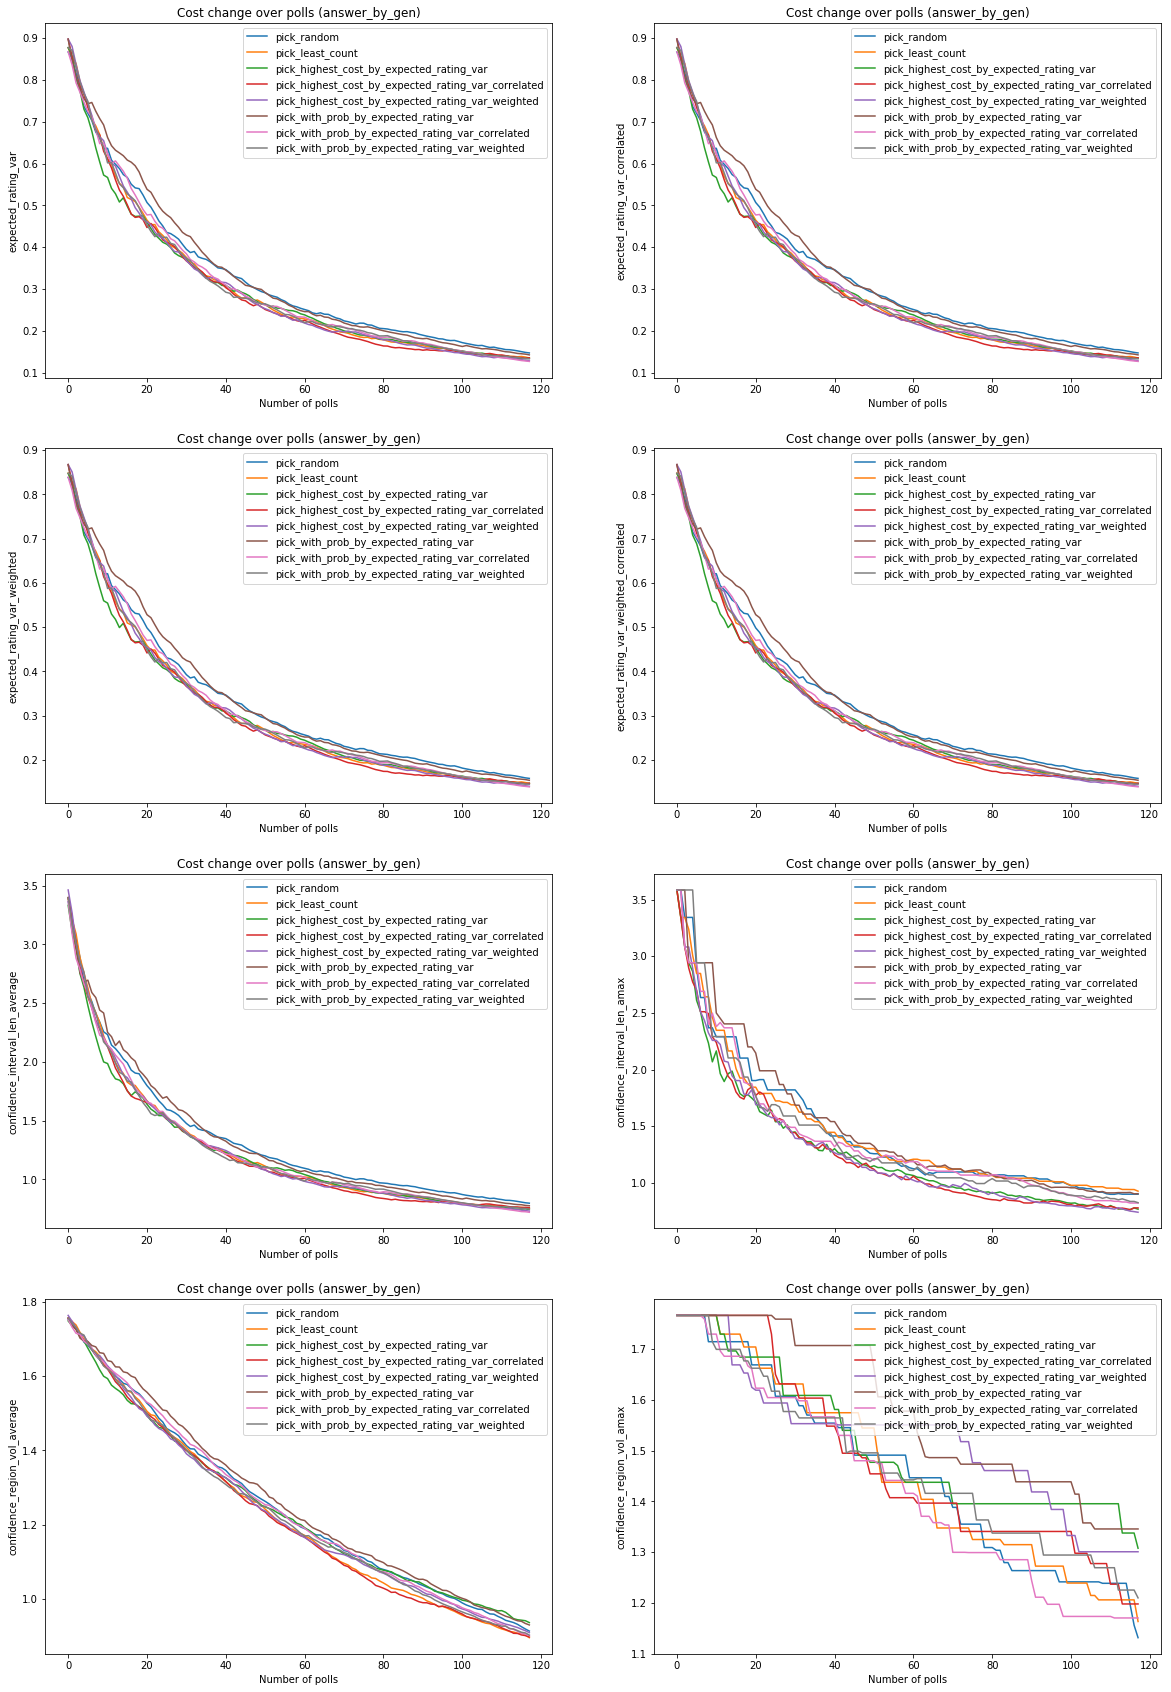

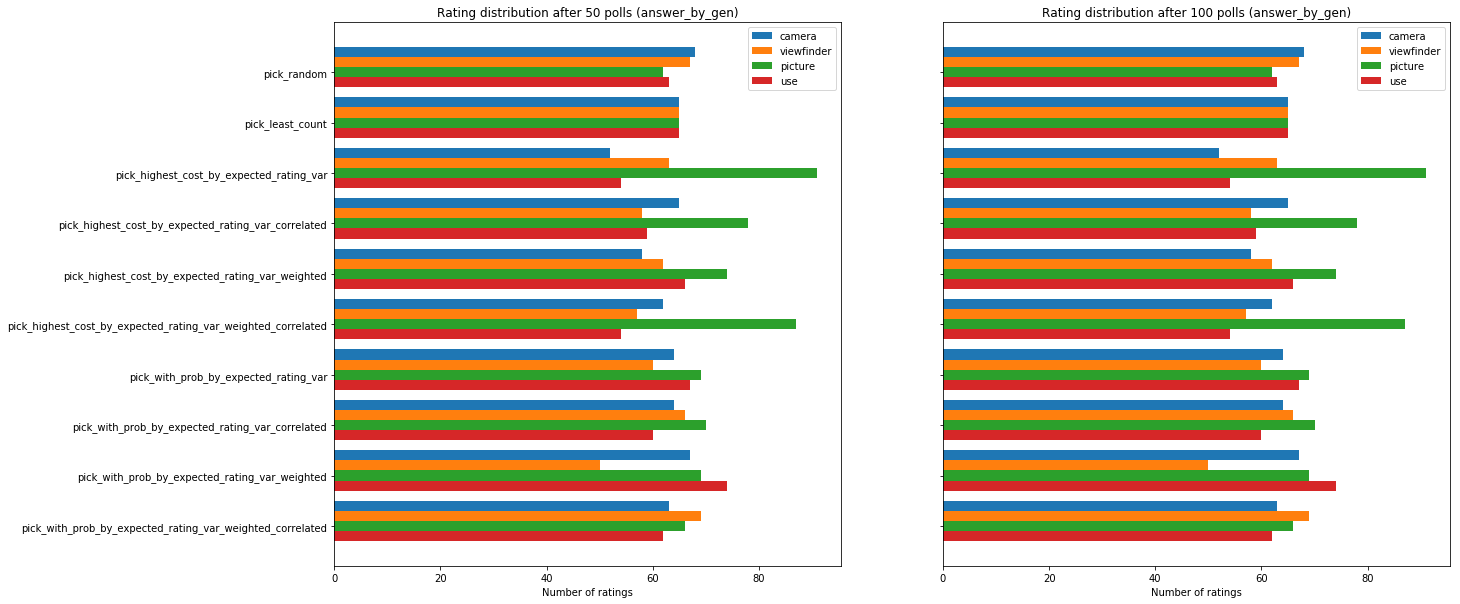

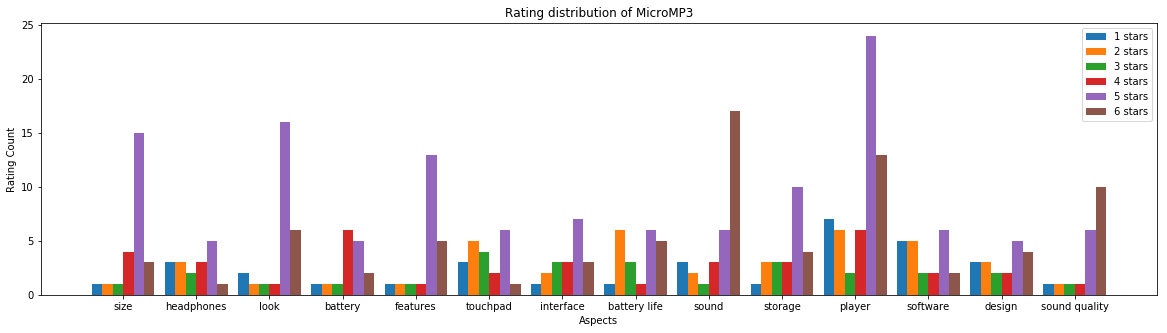

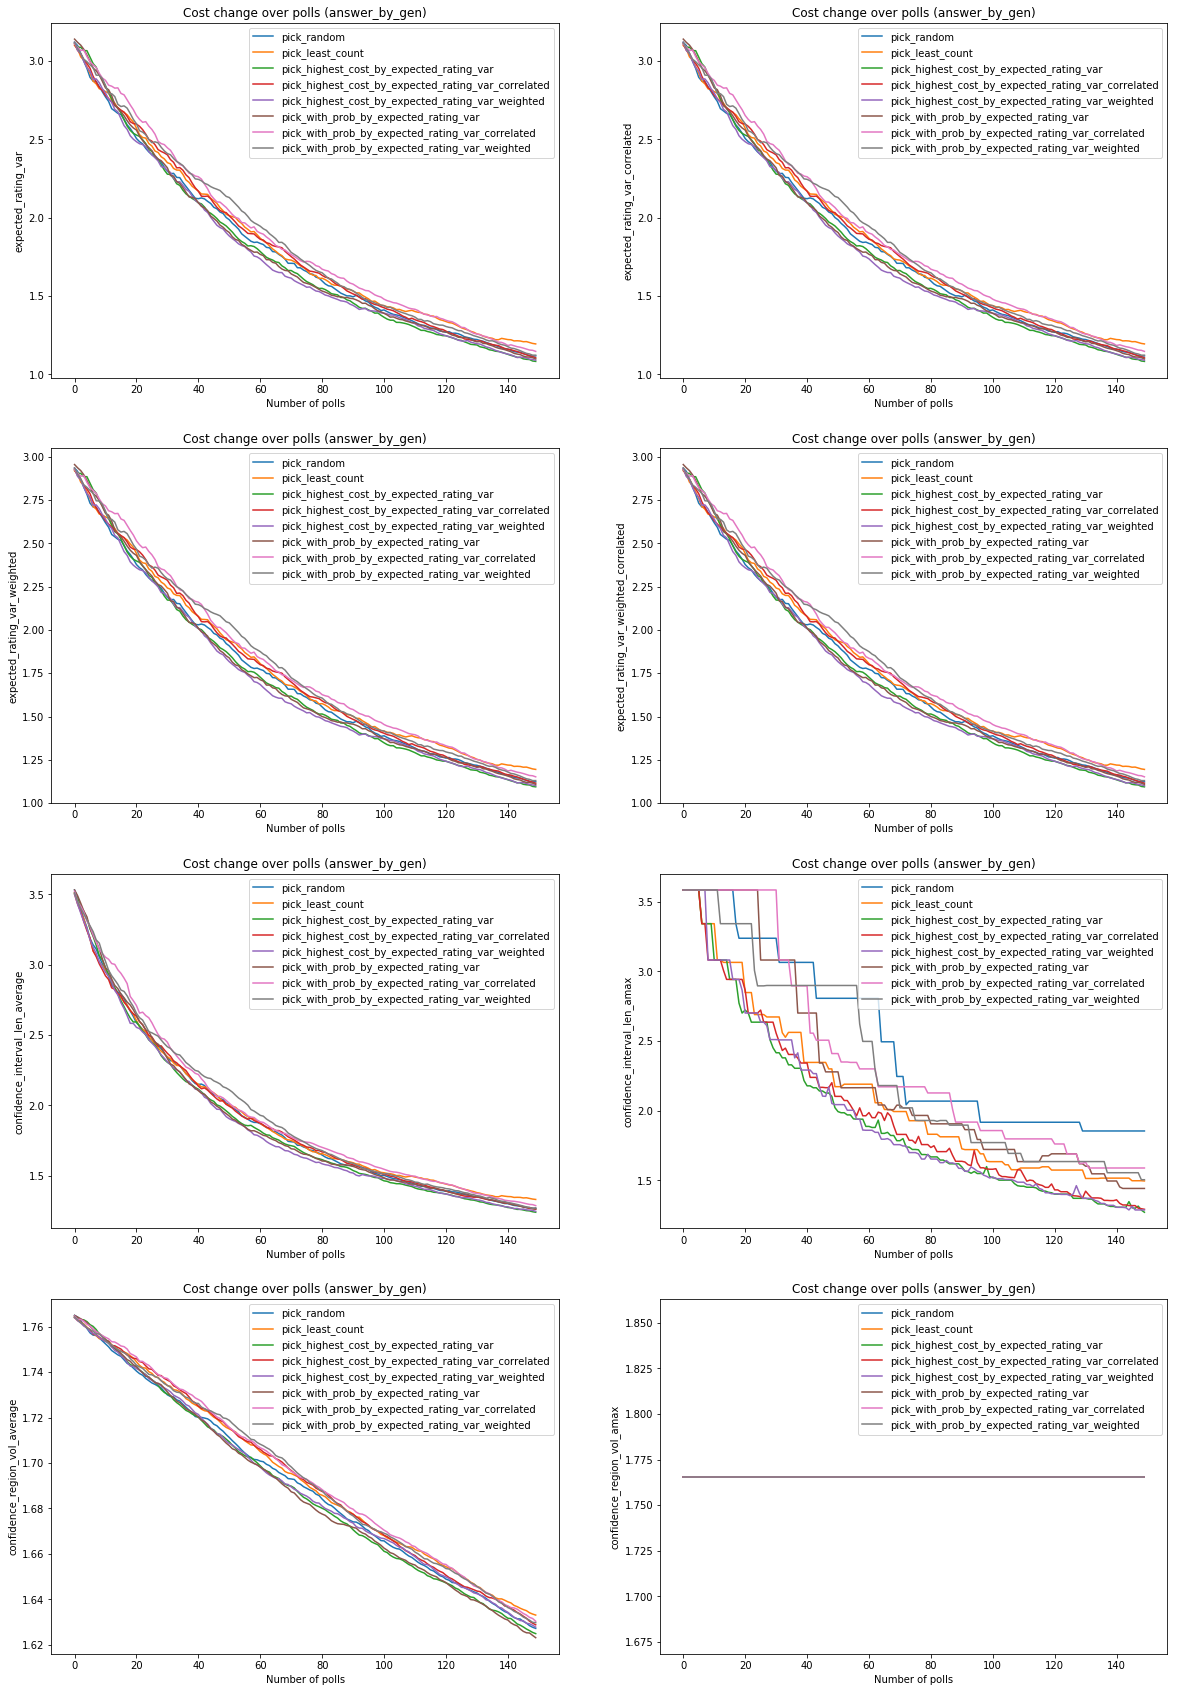

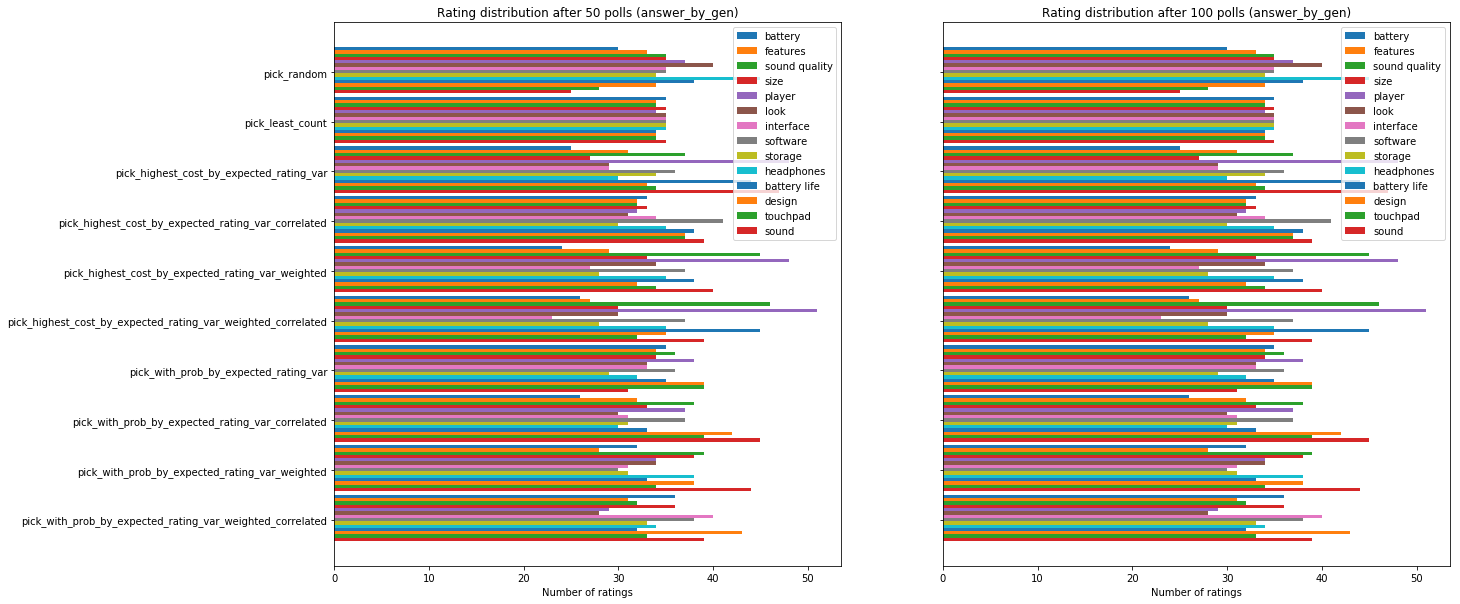

In [6]:
import bliu

bliu_pdf = PdfPages('plots/bliu_p200.pdf')
bliu_result_paths = ['output/bliu_l100_p200_q2.pickle']
path_to_product_stats = OrderedDict()
    
product_to_aspect_sentiments = bliu.BliuReview.import_dataset_with_aspects(
        "anno-datasets/bliu-datasets")

for path in bliu_result_paths:
    with open(path, 'rb') as f:
        product_to_config_stats = pickle.load(f)
        path_to_product_stats[path] = product_to_config_stats

for path, product_to_stats in path_to_product_stats.items():
    print('------------------------{}------------------------\n'.format(path))
    goal_to_stats_average = soli_start.summary_product_to_config_stats(
        product_to_stats, plotted_poll_end=100, ignore_rating=True)
    fig = plot_pick_answer_goals(
        goal_to_stats_average, dataset="bliu", poll_max=150, fig_h=30)
    fig.suptitle('Average over all products', fontsize=15, fontweight='bold')
    bliu_pdf.savefig(fig)

for path, product_to_stats in path_to_product_stats.items():
    print('------------------------{}------------------------\n'.format(path))
    for product, goal_to_stats in product_to_stats.items():
        fig = plot_aspect_rating_dist(product,
                                      product_to_aspect_sentiments[product])
        fig.suptitle(product, fontsize=15, fontweight='bold')
        bliu_pdf.savefig(fig)
        
        bliu_pdf.savefig(plot_pick_answer_goals(goal_to_stats, poll_max=150,
                                                fig_h=30, dataset='bliu'))     
        bliu_pdf.savefig(plot_ratings(goal_to_stats,
                                      dataset="bliu", polls=[50, 100], fig_h=10))
        
bliu_pdf.close()